In [ ]:
#installazione delle librerie necessarie

%pip install librosa numpy matplotlib scikit-learn soundfile datasets evaluate transformers torch noisereduce accelerate


In [1]:
from datasets import Dataset, Audio as DatasetAudio
import evaluate
import numpy as np
import torch
import os
from glob import glob
import json
import re
import csv
import librosa
import soundfile as sf
import noisereduce as nr
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

/home/gtimpano/Scrivania/Giuseppe/SegnaliVocali/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
input_folder = "dataset_TORGO" 
output_folder = "dataset_TORGO_processato"

In [26]:
model_name = "facebook-wav2vec2-base"
#model_name = "MIT-ast-finetuned-audioset-10-10-0.4593"

In [ ]:
#pre processing audio

os.makedirs(output_folder, exist_ok=True)

def highpass_filter(y, sr, cutoff=100, order=5):
    nyquist = 0.5 * sr
    normal_cutoff = cutoff / nyquist
    b, a = scipy.signal.butter(order, normal_cutoff, btype='high', analog=False)
    y_filtered = scipy.signal.lfilter(b, a, y)
    return y_filtered

for class_name in os.listdir(input_folder):
    class_input_path = os.path.join(input_folder, class_name)
    class_output_path = os.path.join(output_folder, class_name)
    if not os.path.isdir(class_input_path):
        continue
    os.makedirs(class_output_path, exist_ok=True)

    for filename in os.listdir(class_input_path):
        if not filename.lower().endswith(('.wav', '.flac', '.mp3')):
            continue

        input_file = os.path.join(class_input_path, filename)
        output_file = os.path.join(class_output_path, filename)

        y, sr = librosa.load(input_file, sr=None)

        #estrai un segmento di rumore (es. i primi 0.5 secondi)
        noise_sample = y[:int(0.5 * sr)]

        # Riduzione del rumore
        if(len(noise_sample) < sr // 10 or
           np.isnan(noise_sample).any() or
           np.all(noise_sample == 0) or
           np.max(np.abs(noise_sample)) < 1e-5
           ):
            print("Riduzione del rumore non valido")
            y_denoised = y
        else:
            y_denoised = nr.reduce_noise(y=y, sr=sr, y_noise=noise_sample)
            if np.isnan(y_denoised).any():
                print("ERRORE file corrotto o altro, skippo il file")
                continue
        
        #Applicazione del filtro passa alto
        y_filtered = highpass_filter(y_denoised, sr, cutoff=30, order=3)

        # Normalizzazione e trimming
        y_normalized = librosa.util.normalize(y_filtered)
        
        #y_trimmed, _ = librosa.effects.trim(y_normalized, top_db=30)
        y_trimmed, _ = librosa.effects.trim(y_normalized, top_db=10)
        
        sf.write(output_file, y_trimmed, sr)

        print(f"Processato {class_name}/{filename}")




In [37]:
#dataset -> csv
def create_csv_from_dataset(root_dir, output_csv):
    """
    Crea un file CSV da un dataset di segnali vocali.
    Il CSV conterrà i percorsi dei file audio e le loro etichette.
    """

    root_dir = root_dir 
    output_csv = output_csv

#Lista per salvare i dati
    data = []

    #Scorri ogni sottocartella/classe
    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_path):
            continue  # Salta file non-cartelle

        for file_name in os.listdir(class_path):
            if class_name == 'HEALTHY':
                class_name_append = 0
            elif class_name == 'UNHEALTHY':
                class_name_append = 1

            #elif class_name == 'PARKINSON':
            #    class_name_append = 2
            
            else:
                continue
            file_path = os.path.join(class_path, file_name)
            if os.path.isfile(file_path):
                data.append([file_path, class_name_append])

    #Scrivi tutto in un CSV
    with open(output_csv, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["path", "label"])  # Header
        writer.writerows(data)

    print(f"CSV salvato in {output_csv} con {len(data)} elementi")

create_csv_from_dataset(output_folder, "dataset.csv")
create_csv_from_dataset(input_folder, "original_dataset.csv")

CSV salvato in dataset.csv con 1474 elementi
CSV salvato in original_dataset.csv con 1474 elementi


In [38]:
#carico il dataset
def load_dataset_from_csv(csv_file):
    """
    Carica un dataset da un file CSV.
    """
    df = pd.read_csv(csv_file)
    return Dataset.from_pandas(df)

dataset = load_dataset_from_csv("dataset.csv")
original_dataset = load_dataset_from_csv("original_dataset.csv")


print(dataset)
print(original_dataset)


Dataset({
    features: ['path', 'label'],
    num_rows: 1474
})
Dataset({
    features: ['path', 'label'],
    num_rows: 1474
})


In [ ]:
#Ascolto/Visualizzazione dei file audio
from IPython.display import Audio, display
import random


def compute_rms_db(audio):
    rms = librosa.feature.rms(y=audio)[0]
    return librosa.amplitude_to_db(rms, ref=np.max)

def get_matching_key(path):
    parts = path.split(os.sep)
    return os.path.join(parts[-2], parts[-1])

original_dict = {get_matching_key(x['path']) : x for x in original_dataset}

# Campiona 5 esempi dal dataset
indices = random.sample(range(len(dataset)), 5)

output_dir = f"{model_name}/{input_folder}/results/imgs"
os.makedirs(output_dir, exist_ok=True)

for i in indices:
    proc_example = dataset[i]

    file_id = get_matching_key(proc_example['path'])

    raw_example = original_dict.get(file_id)

    proc_audio_path = proc_example['path']  # path al file audio
    raw_audio_path = raw_example['path']  # path al file audio originale


    proc_label = proc_example['label']
    raw_label = raw_example['label']

    # Carica l'audio dal file
    proc_audio, sr_proc = librosa.load(proc_audio_path, sr=None)
    raw_audio, sr_raw = librosa.load(raw_audio_path, sr=None)

    print(proc_audio_path)
    print(raw_audio_path)

    label = proc_example['label']

    proc_rms_db = compute_rms_db(proc_audio)
    raw_rms_db = compute_rms_db(raw_audio)

    print(f"\nEsempio {i} - Label: {label}")
    print("  [ORIGINAL]")
    print(f"    Max dB: {np.max(raw_rms_db):.2f}")
    print(f"    Min dB: {np.min(raw_rms_db):.2f}")
    print(f"    Mean dB: {np.mean(raw_rms_db):.2f}")
    print(f"    Median dB: {np.median(raw_rms_db):.2f}")
    print("  [PROCESSATO]")
    print(f"    Max dB: {np.max(proc_rms_db):.2f}")
    print(f"    Min dB: {np.min(proc_rms_db):.2f}")
    print(f"    Mean dB: {np.mean(proc_rms_db):.2f}")
    print(f"    Median dB: {np.median(proc_rms_db):.2f}")

    # Plot
    plt.figure(figsize=(12, 10))

    # Istogrammi RMS
    plt.subplot(3, 2, 3)
    plt.hist(raw_rms_db, bins=100, alpha=0.7, color='gray')
    plt.title("Istogramma RMS dB - Originale")
    plt.xlabel("dB")
    plt.ylabel("Frequenza")
    plt.grid(True)

    plt.subplot(3, 2, 4)
    plt.hist(proc_rms_db, bins=100, alpha=0.7, color='steelblue')
    plt.title("Istogramma RMS dB - Processato")
    plt.xlabel("dB")
    plt.ylabel("Frequenza")
    plt.grid(True)

    plt.subplot(3,2,1)
    plt.plot(raw_audio, color='gray')
    plt.title("Waweform - Originale")
    
    plt.subplot(3,2,2)
    plt.plot(proc_audio, color='steelblue')
    plt.title("Waweform - Processato")

    # Spettrogrammi
    D_raw = librosa.stft(raw_audio)
    S_raw_db = librosa.amplitude_to_db(np.abs(D_raw), ref=np.max)
    plt.subplot(3, 2, 5)
    librosa.display.specshow(S_raw_db, sr=sr_raw, x_axis='time', y_axis='log', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Spettrogramma - Originale")

    D_proc = librosa.stft(proc_audio)
    S_proc_db = librosa.amplitude_to_db(np.abs(D_proc), ref=np.max)
    plt.subplot(3, 2, 6)
    librosa.display.specshow(S_proc_db, sr=sr_proc, x_axis='time', y_axis='log', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Spettrogramma - Processato")

    plt.tight_layout()

    plot_filename = f"audio_example_{i}.png"
    plot_path = os.path.join(output_dir, plot_filename)
    plt.savefig(plot_path,dpi=300)
    
    plt.show()

    # Riproduzione audio
    print("Audio originale:")
    display(Audio(data=raw_audio, rate=sr_raw))

    print("Audio processato:")
    display(Audio(data=proc_audio, rate=sr_proc))

In [39]:
#Inizio training
#from trasformers import AutoFeatureExtractor

dataset = dataset.train_test_split(test_size=0.2)  # 80% training, 20% test
dataset_v = dataset['test'].train_test_split(test_size=0.5) # 10% validation, 10% test
train_dataset = dataset['train']
validation_dataset = dataset_v['train']
test_dataset = dataset_v['test']
print(train_dataset)

Dataset({
    features: ['path', 'label'],
    num_rows: 1179
})


In [40]:
labels = sorted(set(record['label'] for record in dataset['train']))
label2id,id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label


In [41]:
def read_audio(path):
    audio, sr = librosa.load(path, sr=None)
    audio = librosa.resample(audio, orig_sr=sr, target_sr=16000)  # Resampling a 16kHz
    return audio 

In [42]:
#La maggior parte dei modelli richiedono un sr di 16kHz

from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base")
#feature_extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

# Calcola la durata massima dei campioni audio
max_len_samples = max(len(read_audio(x["path"])) for x in train_dataset)
#max_duration_seconds = max_len_samples / feature_extractor.sampling_rate

max_duration_seconds = 10

print(max_duration_seconds)


def preprocess_function(records):
    """
    Preprocessa i dati audio per il modello.
    """
    audio_arrays = read_audio(records["path"])
    inputs = feature_extractor(
        audio_arrays, 
        sampling_rate=feature_extractor.sampling_rate, 
        max_length = int(feature_extractor.sampling_rate * max_duration_seconds), 
        padding='max_length',
        return_tensors='np',
        truncation=True
        )
    inputs["input_values"] = inputs["input_values"].squeeze()
    inputs["labels"] = records["label"]
    return inputs

train_encoded_dataset = train_dataset.map(preprocess_function, remove_columns=['path', 'label'], batched=False)
validation_dataset = validation_dataset.map(preprocess_function, remove_columns=['path', 'label'], batched=False)
test_dataset = test_dataset.map(preprocess_function, remove_columns=['path', 'label'], batched=False)

/home/gtimpano/Scrivania/Giuseppe/SegnaliVocali/env/lib/python3.11/site-packages/transformers/configuration_utils.py:315: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


10


Map: 100%|██████████| 148/148 [00:00<00:00, 635.17 examples/s] 


In [43]:
def compute_metrics(pred):
    import torch
    from evaluate import load

    logits = pred.predictions
    labels = pred.label_ids
    preds = logits.argmax(-1)
    num_classes = logits.shape[1]

    prob_preds = torch.softmax(torch.tensor(logits), dim=-1).numpy()

    accuracy = load("accuracy").compute(predictions=preds, references=labels)
    f1 = load("f1").compute(predictions=preds, references=labels, average='weighted')
    recall = load("recall").compute(predictions=preds, references=labels, average='weighted')
    precision = load("precision").compute(predictions=preds, references=labels, average='weighted')

    metrics = {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"],
        "recall": recall["recall"],
        "precision": precision["precision"]
    }

    try:
        if num_classes == 2:
            auc_metric = load("roc_auc")
            auc = auc_metric.compute(
                references=labels,
                prediction_scores=prob_preds[:, 1] 
            )
        else:
            auc_metric = load("roc_auc", "multiclass")
            auc = auc_metric.compute(
                references=labels,
                prediction_scores=prob_preds,
                multi_class="ovr",
                average="weighted"
            )
        metrics["auc"] = auc["roc_auc"]
    except Exception as e:
        print(f"AUC not applicable: {e}")

    return metrics
    


In [ ]:
#Training del modello
from transformers import AutoModelForAudioClassification, TrainingArguments, Trainer, ASTForAudioClassification

num_labels = len(id2label)

'''model = AutoModelForAudioClassification.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)'''

model = AutoModelForAudioClassification.from_pretrained(
    "MIT/ast-finetuned-audioset-10-10-0.4593",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)
    

os.makedirs("results_models", exist_ok=True)

training_args = TrainingArguments(
    output_dir=f"{model_name}/{input_folder}/results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
)

training_args = training_args.set_optimizer(weight_decay=1e-5)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_encoded_dataset,
    eval_dataset=validation_dataset,
    processing_class=feature_extractor,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision,Auc
1,0.786000,0.706993,0.734848,0.710159,0.734848,0.712661,0.878536
2,0.501700,0.417126,0.878788,0.875778,0.878788,0.874393,0.950966
3,0.347200,0.309979,0.901515,0.901231,0.901515,0.909985,0.975647
4,0.209100,0.395917,0.840909,0.816249,0.840909,0.819204,0.982046
5,0.201800,0.260752,0.916667,0.913240,0.916667,0.915358,0.988234
6,0.172700,0.147494,0.946970,0.941568,0.946970,0.948797,0.992255
7,0.124800,0.142792,0.954545,0.944923,0.954545,0.958134,0.986320
8,0.088800,0.121035,0.962121,0.959419,0.962121,0.963367,0.994808
9,0.046800,0.081441,0.977273,0.976125,0.977273,0.977621,0.997204


/home/gtimpano/Scrivania/Giuseppe/SegnaliVocali/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gtimpano/Scrivania/Giuseppe/SegnaliVocali/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=330, training_loss=0.28960669492230273, metrics={'train_runtime': 1203.5399, 'train_samples_per_second': 8.799, 'train_steps_per_second': 0.274, 'total_flos': 9.3501091656288e+17, 'train_loss': 0.28960669492230273, 'epoch': 9.721804511278195})

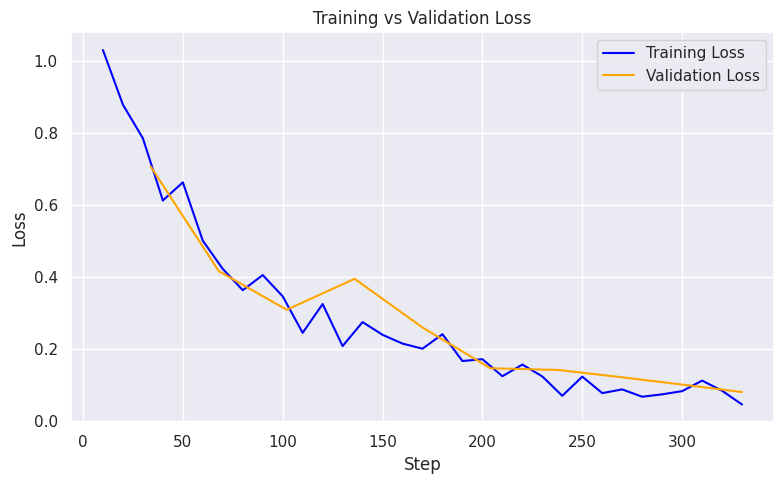

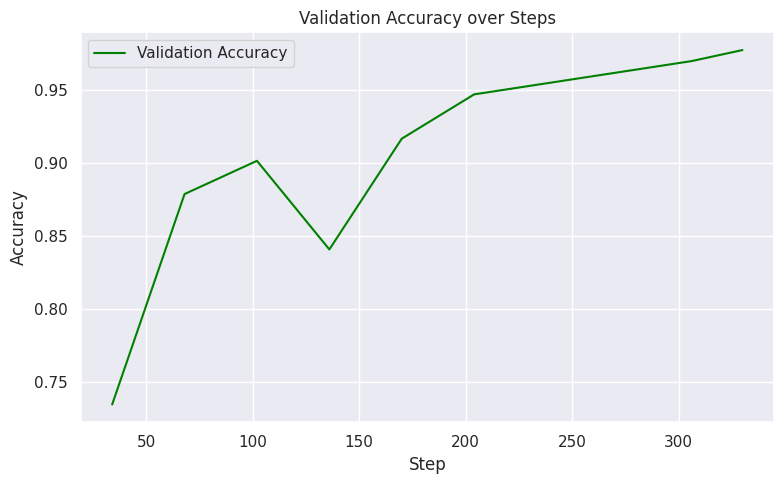

In [55]:
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Path alla cartella di output del training
results_dir = f"{model_name}/{input_folder}/results"

# Lista tutte le cartelle checkpoint e ordinale per numero crescente
checkpoint_dirs = [d for d in os.listdir(results_dir) if d.startswith("checkpoint-")]

if not checkpoint_dirs:
    raise ValueError("Nessun checkpoint trovato in: " + results_dir)

# Estrai il numero da ogni checkpoint (esempio: checkpoint-204 -> 204)
def get_checkpoint_num(name):
    m = re.search(r"checkpoint-(\d+)", name)
    return int(m.group(1)) if m else -1

checkpoint_dirs = sorted(checkpoint_dirs, key=get_checkpoint_num)

# Prendi l'ultimo (il checkpoint con numero più alto)
last_checkpoint = checkpoint_dirs[-1]

trainer_state_path = os.path.join(results_dir, last_checkpoint, "trainer_state.json")
#trainer_state_path = "trainer_state.json"
# Leggi il file JSON
with open(trainer_state_path, "r") as f:
    state = json.load(f)

log_history = state.get("log_history", [])

# Estrai le metriche
train_loss = []
eval_loss = []
eval_accuracy = []
steps_train = []
steps_eval = []

for log in log_history:
    if "loss" in log:
        train_loss.append(log["loss"])
        steps_train.append(log["step"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
        steps_eval.append(log["step"])
    if "eval_accuracy" in log:
        eval_accuracy.append(log["eval_accuracy"])
        

img_dir = os.path.join(results_dir, "imgs")
os.makedirs(img_dir, exist_ok=True) 

# Plot dei loss
sns.set_theme(style="darkgrid")
plt.figure(figsize=(8, 5))
plt.plot(steps_train, train_loss, label="Training Loss", color="blue")
plt.plot(steps_eval, eval_loss, label="Validation Loss", color="orange")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
loss_plot_path = os.path.join(img_dir, "loss_plot.png")
plt.savefig(loss_plot_path, dpi=300)
plt.show()

#Plot dell'accuracy
if eval_accuracy:
    plt.figure(figsize=(8, 5))
    plt.plot(steps_eval, eval_accuracy, label="Validation Accuracy", color="green")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy over Steps")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    acc_plot_path = os.path.join(img_dir, "accuracy_plot.png")
    plt.savefig(acc_plot_path, dpi=300)
    plt.show()


In [ ]:
#Inferenza

from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, TrainingArguments, Trainer
import torch

#Selezionare il miglior modello
#best_model_path = 'MIT-ast-finetuned-audioset-10-10-0.4593/Multiclass_dataset/results/checkpoint-204'

# Lista tutte le cartelle checkpoint
checkpoint_dirs = [d for d in os.listdir(results_dir) if d.startswith("checkpoint-")]
if not checkpoint_dirs:
    raise ValueError("Nessun checkpoint trovato in: " + results_dir)

# Ordina per numero di checkpoint 
def get_checkpoint_num(name):
    m = re.search(r"checkpoint-(\d+)", name)
    return int(m.group(1)) if m else -1

checkpoint_dirs = sorted(checkpoint_dirs, key=get_checkpoint_num)

# Prendi l'ultimo checkpoint (più recente)
last_checkpoint = checkpoint_dirs[-1]

# Leggi il trainer_state.json dall'ultimo checkpoint
trainer_state_path = os.path.join(results_dir, last_checkpoint, "trainer_state.json")

with open(trainer_state_path, "r") as f:
    state = json.load(f)

best_model_path = state.get("best_model_checkpoint")
if best_model_path is None:
    raise ValueError("best_model_checkpoint non trovato in trainer_state.json")

print(f"Percorso miglior modello: {best_model_path}")


feature_extractor = AutoFeatureExtractor.from_pretrained(best_model_path)
model = AutoModelForAudioClassification.from_pretrained(best_model_path)

args = TrainingArguments(
    output_dir="./test_results",
    per_device_eval_batch_size=8,
    dataloader_drop_last=False
)

trainer = Trainer(
    model = model,
    args = args,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor
)

result = trainer.predict(test_dataset)

predicted_labels = np.argmax(result.predictions,axis=1)
real_labels = result.label_ids
metrics = result.metrics
predicted_logits = result.predictions

print(metrics)

/tmp/ipykernel_493720/3668964099.py:48: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'test_loss': 1.512627124786377, 'test_model_preparation_time': 0.0021, 'test_accuracy': 0.5878378378378378, 'test_f1': 0.4804381327986478, 'test_recall': 0.5878378378378378, 'test_precision': 0.433501847170912, 'test_auc': 0.41331757289204096, 'test_runtime': 13.4712, 'test_samples_per_second': 10.986, 'test_steps_per_second': 1.41}


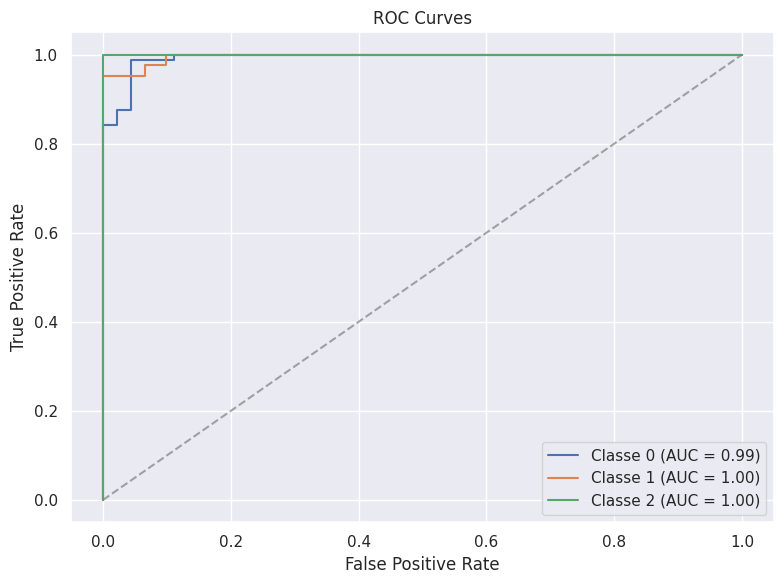

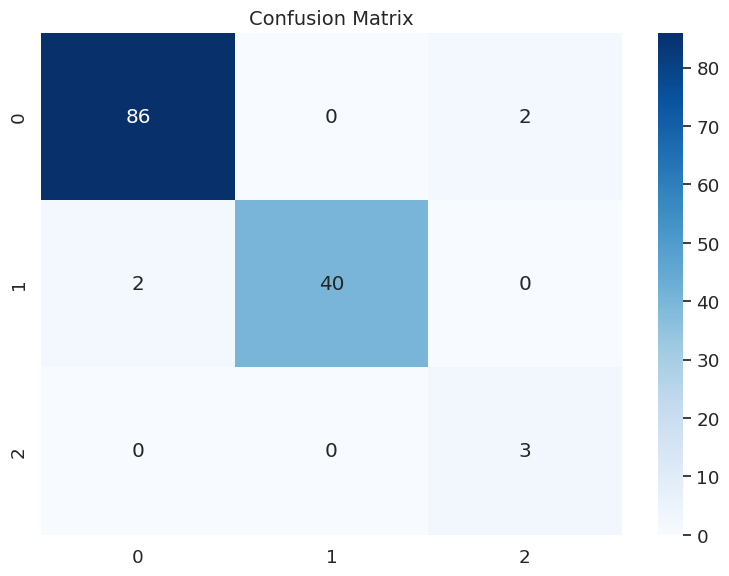

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        88
           1       1.00      0.95      0.98        42
           2       0.60      1.00      0.75         3

    accuracy                           0.97       133
   macro avg       0.86      0.98      0.90       133
weighted avg       0.98      0.97      0.97       133



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

output_dir = f"{model_name}/{input_folder}/results/imgs"
os.makedirs(output_dir, exist_ok=True)

cm = confusion_matrix(real_labels, predicted_labels)
labels = [str(i) for i in range(cm.shape[0])]

n_classes = predicted_logits.shape[1]


plt.figure(figsize=(8,6))
sns.set_theme(style="darkgrid")

if n_classes == 2:
    # Per il caso binario, usa direttamente real_labels se sono già 0/1
    if set(real_labels) == {0, 1}:
        y_true = real_labels
    else:
        y_true = label_binarize(real_labels, classes=list(range(n_classes)))
        y_true = y_true.ravel()  # Flatten per binario
    
    scores = predicted_logits[:, 1]
    fpr, tpr, _ = roc_curve(y_true, scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Binario (AUC = {roc_auc:.2f})")
else:
    y_true = label_binarize(real_labels, classes=list(range(n_classes)))
    for i in range(n_classes):
        fpr_i, tpr_i, _ = roc_curve(y_true[:,i], predicted_logits[:,i])
        auc_i = auc(fpr_i, tpr_i)
        plt.plot(fpr_i, tpr_i, label=f"Classe {i} (AUC = {auc_i:.2f})")

plt.plot([0,1],[0,1],linestyle='--', color='gray', alpha=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")  
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "roc_curves.png"), dpi=300)
plt.show()


sns.set_theme(style="darkgrid")
plt.figure(figsize=(8,6))
sns.set_theme(style="whitegrid",font_scale=1.2)
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues",xticklabels=labels,yticklabels=labels,cbar=True)
plt.title("Confusion Matrix", fontsize=14)
plt.tight_layout()
save_path = os.path.join(output_dir, "confusion_matrix.png")
plt.savefig(save_path, dpi=300)
plt.show()

report = classification_report(real_labels, predicted_labels)
print(report)

output_dir = f"{model_name}/{input_folder}/results"
os.makedirs(output_dir, exist_ok=True)

report_path = os.path.join(output_dir, "classification_report.txt")

with open(report_path, "w") as f:
    f.write(report)

